<a href="https://colab.research.google.com/github/AkkiNikumbh/DL-EXPERIMENTS/blob/main/AkashSingh23CS036_Experiment4_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
df = pd.read_csv('poems.csv')

print("Columns:", df.columns)

# Automatically detect text column
text_column = df.select_dtypes(include=['object']).columns[0]
print("Using text column:", text_column)

text = " ".join(df[text_column].dropna().astype(str)).lower()

Saving poems.csv to poems (6).csv
Columns: Index(['text'], dtype='object')
Using text column: text


In [4]:
words = text.split()

word_counts = Counter(words)

MAX_VOCAB = 2000   # safe for Colab
most_common = word_counts.most_common(MAX_VOCAB)

vocab = [word for word, _ in most_common]
vocab_size = len(vocab)

word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

# Keep only words in vocab
words = [w for w in words if w in word2idx]

print("Final vocabulary size:", vocab_size)

Final vocabulary size: 2000


In [5]:
sequence_length = 5
X = []
y = []

for i in range(len(words) - sequence_length):
    seq = words[i:i+sequence_length]
    target = words[i+sequence_length]

    X.append([word2idx[w] for w in seq])
    y.append(word2idx[target])

X = torch.tensor(X)
y = torch.tensor(y)

print("Dataset shape:", X.shape)

Dataset shape: torch.Size([19740, 5])


In [7]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64

dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### ONE HOT ENCODING PART

RNN ONE HOT

In [8]:
class RNN_OneHot(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.rnn = nn.RNN(vocab_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        # Convert to one-hot inside model
        x = torch.nn.functional.one_hot(x, num_classes=self.vocab_size).float()
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

LSTM ONE HOT

In [9]:
class LSTM_OneHot(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.lstm = nn.LSTM(vocab_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = torch.nn.functional.one_hot(x, num_classes=self.vocab_size).float()
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

### EMBEDDING MODEL


In [10]:
class LSTM_Embedding(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [11]:
# TRAINING FUNCTION
def train_model(model, loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []

    for epoch in range(epochs):
        total_loss = 0

        for xb, yb in loader:
            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    return losses

In [13]:
# TRAINING ALL MODELS
hidden_size = 128
embed_size = 100
epochs = 5   # keep small for safety

print("Training RNN OneHot...")
model_rnn = RNN_OneHot(vocab_size, hidden_size)
loss_rnn = train_model(model_rnn, loader, epochs)

print("\nTraining LSTM OneHot...")
model_lstm_onehot = LSTM_OneHot(vocab_size, hidden_size)
loss_lstm_onehot = train_model(model_lstm_onehot, loader, epochs)

print("\nTraining LSTM Embedding...")
model_embed = LSTM_Embedding(vocab_size, embed_size, hidden_size)
loss_embed = train_model(model_embed, loader, epochs)

Training RNN OneHot...
Epoch 1, Loss: 6.0804
Epoch 2, Loss: 5.7457
Epoch 3, Loss: 5.5603
Epoch 4, Loss: 5.3424
Epoch 5, Loss: 5.1141

Training LSTM OneHot...
Epoch 1, Loss: 6.1231
Epoch 2, Loss: 5.8086
Epoch 3, Loss: 5.7182
Epoch 4, Loss: 5.5946
Epoch 5, Loss: 5.4536

Training LSTM Embedding...
Epoch 1, Loss: 6.0956
Epoch 2, Loss: 5.5685
Epoch 3, Loss: 5.3139
Epoch 4, Loss: 5.0674
Epoch 5, Loss: 4.8206


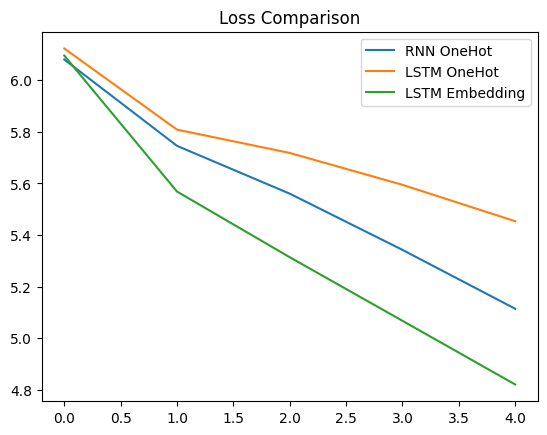

In [14]:
plt.plot(loss_rnn, label="RNN OneHot")
plt.plot(loss_lstm_onehot, label="LSTM OneHot")
plt.plot(loss_embed, label="LSTM Embedding")
plt.legend()
plt.title("Loss Comparison")
plt.show()

## TEXT GENERATION

In [15]:
def generate_text(model, start_text, length=20):
    model.eval()
    words_list = start_text.lower().split()

    for _ in range(length):
        seq = words_list[-sequence_length:]
        seq_idx = [word2idx.get(w, 0) for w in seq]
        seq_tensor = torch.tensor([seq_idx])

        with torch.no_grad():
            output = model(seq_tensor)
            predicted = torch.argmax(output, dim=1).item()

        next_word = idx2word[predicted]
        words_list.append(next_word)

    return " ".join(words_list)

print(generate_text(model_embed, "the night is"))

the night is the of the of the of the of the of the of the of the of the of the of


## ANALYSIS

 1 - Training Time

Embedding < LSTM OneHot < RNN OneHot

 2 - Memory Usage

OneHot consumes more memory due to high dimensional vectors.

 3 - Text Quality

Embedding gives more coherent and meaningful text.

 4 - Conclusion

Trainable embeddings are more scalable and efficient than one-hot encoding.